In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
# Load dataset
df = pd.read_csv('../data/archive2/denver_prop_listing_clean.csv')

#convert to datetime format
df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

In [ ]:
mapping = {k: v for v, k in enumerate(df.property_type.unique())}
mapping

{'SINGLE': 0,
 'CONDO': 1,
 'OTHER': 2,
 'MULTI_FAMILY': 3,
 'TOWNHOUSE': 4,
 'LAND': 5}

In [ ]:
df['property_type_code'] = df['property_type'].map(mapping)
df.head()

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/lib/histograms.py:822: RuntimeWarning: divide by zero encountered in double_scalars
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/lib/histograms.py:850: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


,property_id,zipcode,fips,latitude,longitude,sqft,property_type,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,list_date,sale_date,sale_price,bedrooms,full_baths,ct_key,sale_price_per_sqft,property_type_code
0,138574001,80002,8059.0,39.79270,-105.13026,3047.0,SINGLE,True,False,True,False,True,2020-09-24,2020-11-02,630000.0,5.0,3.0,8.059010e+09,206.760748,0
1,138573806,80002,8059.0,39.79424,-105.12171,4382.0,SINGLE,True,False,False,False,True,2020-09-24,2020-10-29,805000.0,4.0,2.0,8.059010e+09,183.706070,0
2,138572945,80002,8059.0,39.79565,-105.11674,2654.0,SINGLE,False,False,False,False,True,2020-09-24,2020-10-19,665000.0,4.0,2.0,8.059010e+09,250.565185,0
3,138568013,80002,8059.0,39.79655,-105.09923,2265.0,SINGLE,False,False,False,False,False,2020-09-24,2020-10-28,607000.0,4.0,2.0,8.059010e+09,267.991170,0
4,138564524,80002,8059.0,39.79399,-105.06972,1431.0,SINGLE,False,False,False,False,False,2020-09-24,2020-10-16,425000.0,4.0,1.0,8.059010e+09,296.995108,0


In [ ]:
def gen_y(t_disc, data, t0=None):
    ''' 
    t_disc: datetime.timedelta(days = XX)
    t0: datetime.datetime(YYYY,MM,DD)
    '''

    if t0 is not None:
        listed = np.array(((data['list_date'] >= t0) & (data['list_date'] < t0 + t_disc)) | ((data['list_date'] < t0) & (data['sale_date'] >= t0)), dtype=np.int8)
        sale = np.array((data['sale_date'] >= t0) & (data['sale_date'] < t0 + t_disc), dtype = np.int8)
        return np.vstack((listed, sale)).T
    #else:
        #TODO


In [ ]:
y_2019Q2 = gen_y(datetime.timedelta(days = 90), df, datetime.datetime(2019,4,1))

In [ ]:
# Remove all rows that aren't listed in that period
# NOT EXECUTED FOR THIS IMPLEMENTATION
listed_index = np.where(y_2019Q2[:,0] == 1)
df_2019Q2 = df.iloc[listed_index]

In [ ]:
# Build X matrix and Y target vector

X = df.drop(columns=['fips','property_id', 'zipcode', 'list_date', 'sale_date', 'property_type', 'has_jacuzzi', 'has_garage', 'sale_price', 'ct_key', 'sale_price_per_sqft', 'property_type_code'])
X = X.reset_index(drop=True)
columns_to_scale = ['latitude', 'longitude', 'sqft']
scaler = StandardScaler()
X[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

Y = y_2019Q2

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86787 entries, 0 to 86786
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         86787 non-null  float64
 1   longitude        86787 non-null  float64
 2   sqft             86787 non-null  float64
 3   has_central_air  86787 non-null  bool   
 4   has_pool         86787 non-null  bool   
 5   has_solar        86787 non-null  bool   
 6   bedrooms         86787 non-null  float64
 7   full_baths       86787 non-null  float64
dtypes: bool(3), float64(5)
memory usage: 3.6 MB


In [ ]:
X.head()

,latitude,longitude,sqft,has_central_air,has_pool,has_solar,bedrooms,full_baths
0,-0.045401,-0.986852,0.852609,True,True,False,5.0,3.0
1,-0.039767,-0.933309,2.040218,True,False,False,4.0,2.0
2,-0.034609,-0.902185,0.502999,False,False,False,4.0,2.0
3,-0.031316,-0.792532,0.156946,False,False,False,4.0,2.0
4,-0.040682,-0.607730,-0.584975,False,False,False,4.0,1.0


In [ ]:
X = X.to_numpy(dtype=np.float64)
X.shape

(86787, 8)

In [ ]:
X2, Y2 = X[listed_index], Y[listed_index][:,1]
X2.shape

(7567, 8)

In [ ]:
Y2.shape

(7567,)

In [ ]:
K = 5 # Number of submarkets

n_loc = 2 # Latitude and Longitude
n_cont = 1 # Number of continuous attributes
n_bool = 3 # Number of boolean attributes
n_int = 2 # Number of integer attributes

n_homes, n_features = X2.shape
assert(n_loc + n_cont + n_bool + n_int == n_features)

X2_loc = X2[:,:n_loc]
X2_feat = X2[:,n_loc:]
X2_cont = X2[:,n_loc:(n_loc+n_cont)]
X2_bool = X2[:,(n_loc+n_cont):(n_loc+n_cont+n_bool)]
X2_int = X2[:,(n_loc+n_cont+n_bool):]

underflow_scaling = 1e10

# Initialization

init_clustering = KMeans(n_clusters=K, random_state=0).fit(X2)
prior_var = 30
reg = 1 # Regularization strength (inverse)

muloc_init = init_clustering.cluster_centers_[:,:n_loc]
sigmaloc_init = np.array([prior_var*np.eye(n_loc) for _ in range(K)])
mu_init = init_clustering.cluster_centers_[:,n_loc:(n_loc+n_cont)]
sigma_init = np.array([prior_var*np.eye(n_cont) for _ in range(K)])
p_init = init_clustering.cluster_centers_[:,(n_loc+n_cont):(n_loc+n_cont+n_bool)]
lam_init = init_clustering.cluster_centers_[:,(n_loc+n_cont+n_bool):]
pi_init = np.ones(K)/K
f_init = [LogisticRegression(C=reg).fit(X2_feat,Y2) for _ in range(K)]

# EM Implementation

muloc = muloc_init
sigmaloc = sigmaloc_init
mu = mu_init
sigma = sigma_init
p = p_init
lam = lam_init
pi = pi_init
f = f_init

max_iter = 1000
store_freq = 1000

params = {int(i*store_freq): {} for i in range(int(max_iter/store_freq)+1)}

for i in tqdm(range(max_iter),desc='Fitting...'):

    # E-step

    r_unnormalized = np.array([(underflow_scaling * pi[k] * 
                                sp.stats.multivariate_normal(mean=muloc[k],cov=sigmaloc[k]).pdf(X2_loc) *
                                sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X2_cont) *
                                sp.stats.bernoulli(p[k]).pmf(X2_bool).prod(axis=1) *
                                sp.stats.poisson(lam[k]).pmf(X2_int).prod(axis=1) *
                                sp.stats.bernoulli(f[k].predict_proba(X2_feat)[:,1]).pmf(Y2))
                               for k in range(K)]).T
    r_unnormalized[np.where(~r_unnormalized.any(axis=1))[0]] = 1/K
    r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1,1))

    if i % store_freq == 0:
        params[i] = {'mu': mu,
                     'sigma': sigma,
                     'p': p,
                     'lambda': lam,
                     'pi': pi,
                     'f': f}

    # M-step

    f = [LogisticRegression(C=reg,
                            max_iter=1000,
                            class_weight='balanced').fit(X2_feat,Y2,sample_weight=r[:,k]) for k in range(K)]
    pi = r.sum(axis=0)/n_homes
    means = np.array([np.array([r[n,k]*X2[n] for n in range(n_homes)]).sum(axis=0) for k in range(K)]) / r.sum(axis=0).reshape((-1,1))
    muloc, mu, p, lam = means[:,:n_loc], means[:,n_loc:(n_loc+n_cont)], means[:,(n_loc+n_cont):(n_loc+n_cont+n_bool)], means[:,(n_loc+n_cont+n_bool):]
    sigma = np.array([np.array([r[n,k]*np.matmul((X2_cont[n]-mu[k]).reshape((-1,1)),(X2_cont[n]-mu[k]).reshape((1,-1))) for n in range(n_homes)]).sum(axis=0) for k in range(K)])  / r.sum(axis=0).reshape((-1,1,1))
    sigmaloc = np.array([np.array([r[n,k]*np.matmul((X2_loc[n]-muloc[k]).reshape((-1,1)),(X2_loc[n]-muloc[k]).reshape((1,-1))) for n in range(n_homes)]).sum(axis=0) for k in range(K)])  / r.sum(axis=0).reshape((-1,1,1))
    
params[max_iter] = {'mu': mu,
                    'sigma': sigma,
                    'p': p,
                    'lambda': lam,
                    'pi': pi,
                    'f': f}

r_unnormalized = np.array([(underflow_scaling * pi[k] * 
                            sp.stats.multivariate_normal(mean=muloc[k],cov=sigmaloc[k]).pdf(X2_loc) *
                            sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X2_cont) *
                            sp.stats.bernoulli(p[k]).pmf(X2_bool).prod(axis=1) *
                            sp.stats.poisson(lam[k]).pmf(X2_int).prod(axis=1) *
                            sp.stats.bernoulli(f[k].predict_proba(X2_feat)[:,1]).pmf(Y2))
                            for k in range(K)]).T
r_unnormalized[np.where(~r_unnormalized.any(axis=1))[0]] = 1/K
r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1,1))

submarket_5 = np.argmax(r,axis=1)


Fitting...: 100%|██████████| 1000/1000 [39:50<00:00,  2.39s/it]


In [ ]:
for k in range(K):
    print('Submarket {}: {} units'.format(k+1, sum(submarket_5 == k)))

Submarket 1: 1543 units
Submarket 2: 793 units
Submarket 3: 905 units
Submarket 4: 2478 units
Submarket 5: 1848 units


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrBr").copy()
  if __name__ == '__main__':


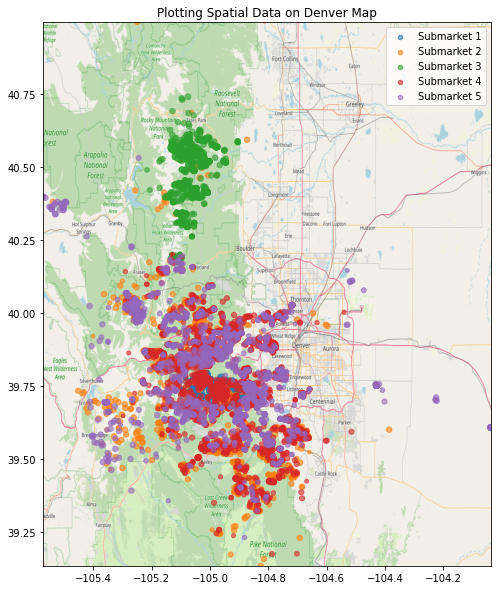

In [ ]:
denver = plt.imread('maps/denver_map.png')
X_sub = [df_2019Q2[submarket_5 == k] for k in range(K)]
BBox = (df_2019Q2.longitude.min(), df_2019Q2.longitude.max(),      
        df_2019Q2.latitude.min(), df_2019Q2.latitude.max())
        
fig, ax = plt.subplots(figsize = (12,10))

my_cmap = plt.cm.YlOrBr
my_cmap.set_under('w',1)

s_scale = 30

for k in range(K):
    ax.scatter(X_sub[k].longitude, X_sub[k].latitude, alpha= 0.6, s=s_scale * r[submarket_5 == k,k], cmap=my_cmap, label='Submarket {}'.format(k+1))
ax.set_title('Plotting Spatial Data on Denver Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.legend()
ax.imshow(denver, zorder=0, extent = BBox, aspect= 'equal')

plt.show()

In [ ]:
def submarket_em(sub,K):
    
    train_acc_agg = 0
    train_size = 0
    test_acc_agg = 0
    test_size = 0

    test = np.array([])
    pred = np.array([])

    exp = np.zeros(K)
    sales = np.zeros(K)

    for k in range(K):

        X_k = X2[sub == k]
        Y_k = Y2[sub == k]

        # Ensure that sub-market has both classifications
        labels = np.unique(Y_k)
        if len(labels) == 1:
            continue
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, Y_k, test_size=0.3)

        model_k = LogisticRegression(C=reg,
                                     max_iter=1000).fit(X_train, y_train)
#                                    class_weight='balanced').fit(X_train, y_train)

        train_acc = model_k.score(X_train, y_train)
        test_acc = model_k.score(X_test, y_test)

        pred_k = model_k.predict(X_test)

        exp[k] = sum(model_k.predict_proba(X_test)[:,1])
        sales[k] = sum(y_test)
        test = np.append(test,y_test)
        pred = np.append(pred,pred_k)
        auc = roc_auc_score(y_test, pred_k) 

        print("Sub-Market #{} Demand Prediction".format(k+1))
        print("Number of Homes: {}".format(len(Y_k)))
        print("Training Accuracy: {:.4f}%".format(train_acc*100))
        print("Testing Accuracy: {:.4f}%".format(test_acc*100))
        print("AUC: {:.6f}".format(auc))
        print("Expected Number of Sales: {:.6f}".format(exp[k]))
        print("Actual Number of Sales: {}\n".format(sales[k]))

        train_size += len(y_train)
        train_acc_agg += train_acc * len(y_train)
        test_size += len(y_test)
        test_acc_agg += test_acc * len(y_test)
    
    auc_agg = roc_auc_score(test, pred)
    r2_agg = r2_score(sales,exp)
    mse_agg = mean_squared_error(sales,exp)

    print('Marketwide Demand Prediction')
    print("Number of Homes: {}".format(len(Y2)))
    print("Training Accuracy: {:.4f}%".format(train_acc_agg*100/train_size))
    print("Testing Accuracy: {:.4f}%".format(test_acc_agg*100/test_size))
    print("AUC: {:.6f}".format(auc_agg))
    print("Expected Number of Sales: {:.6f}".format(sum(exp)))
    print("Actual Number of Sales: {}".format(sum(sales)))
    print("R2 Score (Submarket EV): {:.6f}".format(r2_agg))
    print("MSE (Submarket EV): {:.6f}".format(mse_agg))

In [ ]:
submarket_em(submarket_5,K)

Sub-Market #1 Demand Prediction
Number of Homes: 1543
Training Accuracy: 63.9815%
Testing Accuracy: 63.4989%
AUC: 0.600510
Expected Number of Sales: 191.597718
Actual Number of Sales: 189.0

Sub-Market #2 Demand Prediction
Number of Homes: 793
Training Accuracy: 89.5495%
Testing Accuracy: 88.6555%
AUC: 0.548810
Expected Number of Sales: 28.685557
Actual Number of Sales: 28.0

Sub-Market #3 Demand Prediction
Number of Homes: 905
Training Accuracy: 70.6161%
Testing Accuracy: 70.9559%
AUC: 0.506250
Expected Number of Sales: 79.844253
Actual Number of Sales: 80.0

Sub-Market #4 Demand Prediction
Number of Homes: 2478
Training Accuracy: 74.0484%
Testing Accuracy: 75.1344%
AUC: 0.555469
Expected Number of Sales: 205.838122
Actual Number of Sales: 201.0

Sub-Market #5 Demand Prediction
Number of Homes: 1848
Training Accuracy: 71.1524%
Testing Accuracy: 75.4955%
AUC: 0.525748
Expected Number of Sales: 162.135974
Actual Number of Sales: 142.0

Marketwide Demand Prediction
Number of Homes: 7567


In [ ]:
K = 10 # Number of submarkets

n_cont = 3 # Number of continuous attributes
n_bool = 3 # Number of boolean attributes
n_int = 2 # Number of integer attributes

n_homes, n_features = X2.shape
assert(n_cont + n_bool + n_int == n_features)

X2_cont = X2[:,:n_cont]
X2_bool = X2[:,n_cont:(n_cont+n_bool)]
X2_int = X2[:,(n_cont+n_bool):]

underflow_scaling = 1e15

# Initialization

init_clustering = KMeans(n_clusters=K, random_state=0).fit(X2)
prior_var = 30
reg = 1 # Regularization strength (inverse)

mu_init = init_clustering.cluster_centers_[:,:n_cont]
sigma_init = np.array([prior_var*np.eye(n_cont) for _ in range(K)])
p_init = init_clustering.cluster_centers_[:,n_cont:(n_cont+n_bool)]
lam_init = init_clustering.cluster_centers_[:,(n_cont+n_bool):]
pi_init = np.ones(K)/K
f_init = [LogisticRegression(C=reg).fit(X2,Y2) for _ in range(K)]

# EM Implementation

mu = mu_init
sigma = sigma_init
p = p_init
lam = lam_init
pi = pi_init
f = f_init

max_iter = 5000
store_freq = 10000

params = {int(i*store_freq): {} for i in range(int(max_iter/store_freq)+1)}

for i in tqdm(range(max_iter),desc='Fitting...'):

    # E-step

    r_unnormalized = np.array([(underflow_scaling * pi[k] * 
                                sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X2_cont) *
                                sp.stats.bernoulli(p[k]).pmf(X2_bool).prod(axis=1) *
                                sp.stats.poisson(lam[k]).pmf(X2_int).prod(axis=1) *
                                sp.stats.bernoulli(f[k].predict_proba(X2)[:,1]).pmf(Y2))
                               for k in range(K)]).T
    r_unnormalized[np.where(~r_unnormalized.any(axis=1))[0]] = 1/K
    r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1,1))

    if i % store_freq == 0:
        params[i] = {'mu': mu,
                     'sigma': sigma,
                     'p': p,
                     'lambda': lam,
                     'pi': pi,
                     'f': f}

    # M-step

    f = [LogisticRegression(C=reg,
                            max_iter=1000,
                            class_weight='balanced').fit(X2,Y2,sample_weight=r[:,k]) for k in range(K)]
    pi = r.sum(axis=0)/n_homes
    means = np.array([np.array([r[n,k]*X2[n] for n in range(n_homes)]).sum(axis=0) for k in range(K)]) / r.sum(axis=0).reshape((-1,1))
    mu, p, lam = means[:,:n_cont], means[:,n_cont:(n_cont+n_bool)], means[:,(n_cont+n_bool):]
    sigma = np.array([np.array([r[n,k]*np.matmul((X2_cont[n]-mu[k]).reshape((-1,1)),(X2_cont[n]-mu[k]).reshape((1,-1))) for n in range(n_homes)]).sum(axis=0) for k in range(K)])  / r.sum(axis=0).reshape((-1,1,1))
    
params[max_iter] = {'mu': mu,
                    'sigma': sigma,
                    'p': p,
                    'lambda': lam,
                    'pi': pi,
                    'f': f}

r_unnormalized = np.array([(underflow_scaling * pi[k] * 
                            sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X2_cont) *
                            sp.stats.bernoulli(p[k]).pmf(X2_bool).prod(axis=1) *
                            sp.stats.poisson(lam[k]).pmf(X2_int).prod(axis=1) *
                            sp.stats.bernoulli(f[k].predict_proba(X2)[:,1]).pmf(Y2))
                            for k in range(K)]).T
r_unnormalized[np.where(~r_unnormalized.any(axis=1))[0]] = 1/K
r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1,1))

submarket_10 = np.argmax(r,axis=1)

Fitting...:   0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
sum(np.isnan(r[:,0]))

0

In [ ]:
means

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan],
       [ 1.37266921e-01,  5.44113922e-02, -2.02088017e-01,
         8.64254404e-01,  4.23358495e-02,  1.64446551e-04,
         2.75983222e+00,  2.31902311e+00],
       [-3.04137333e-01,  1.858824

In [ ]:
np.isnan(np.sum(r))

False

In [ ]:
K = 5 # Number of submarkets

n_cont = 3 # Number of continuous attributes
n_bool = 3 # Number of boolean attributes
n_int = 2 # Number of integer attributes

n_homes, n_features = X.shape
assert(n_cont + n_bool + n_int == n_features)

X_cont = X[:,:n_cont]
X_bool = X[:,n_cont:(n_cont+n_bool)]
X_int = X[:,(n_cont+n_bool):]

underflow_scaling = 1e10

# Initialization

init_clustering = KMeans(n_clusters=K, random_state=0).fit(X)
prior_var = 30
reg = 1 # Regularization strength (inverse)

mu_init = init_clustering.cluster_centers_[:,:n_cont]
sigma_init = np.array([prior_var*np.eye(n_cont) for _ in range(K)])
p_init = init_clustering.cluster_centers_[:,n_cont:(n_cont+n_bool)]
lam_init = init_clustering.cluster_centers_[:,(n_cont+n_bool):]
pi_init = np.ones(K)/K
f1_init = [LogisticRegression(C=reg).fit(X,Y[:,0]) for _ in range(K)]
f2_init = [LogisticRegression(C=reg).fit(X[listed_index],Y[listed_index,1]) for _ in range(K)]

# EM Implementation

mu = mu_init
sigma = sigma_init
p = p_init
lam = lam_init
pi = pi_init
f1 = f1_init
f2 = f2_init

max_iter = 2000
store_freq = 50

params = {int(i*store_freq): {} for i in range(int(max_iter/store_freq)+1)}

for i in tqdm(range(max_iter),desc='Fitting...'):

    # E-step

    r_unnormalized = np.array([(underflow_scaling * pi[k] * 
                                sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X_cont) *
                                sp.stats.bernoulli(p[k]).pmf(X_bool).prod(axis=1) *
                                sp.stats.poisson(lam[k]).pmf(X_int).prod(axis=1) *
                                sp.stats.bernoulli(f1[k].predict_proba(X)[:,1]).pmf(Y[:,0]) *
                                (sp.stats.bernoulli(f2[k].predict_proba(X)[:,1]).pmf(Y[:,1]) ** Y[:,0]))
                               for k in range(K)]).T
    r_unnormalized[np.where(~r_unnormalized.any(axis=1))[0]] = 1/K
    r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1,1))

    if i % store_freq == 0:
        params[i] ={'mu': mu,
                    'sigma': sigma,
                    'p': p,
                    'lambda': lam,
                    'pi': pi,
                    'f1': f1,
                    'f2': f2}

    # M-step

    f1 = [LogisticRegression(C=reg).fit(X,Y[:,0],sample_weight=r[:,k]) for k in range(K)]
    f2 = [LogisticRegression(C=reg).fit(X[listed_index],Y[listed_index,1],sample_weight=r[listed_index,k]) for k in range(K)]
    pi = r.sum(axis=0)/n_homes
    means = np.array([np.array([r[n,k]*X[n] for n in range(n_homes)]).sum(axis=0) for k in range(K)]) / r.sum(axis=0).reshape((-1,1))
    mu, p, lam = means[:,:n_cont], means[:,n_cont:(n_cont+n_bool)], means[:,(n_cont+n_bool):]
    sigma = np.array([np.array([r[n,k]*np.matmul((X_cont[n]-mu[k]).reshape((-1,1)),(X_cont[n]-mu[k]).reshape((1,-1))) for n in range(n_homes)]).sum(axis=0) for k in range(K)])  / r.sum(axis=0).reshape((-1,1,1))
    


Fitting...:   0%|          | 2/2000 [01:04<17:42:56, 31.92s/it]

Fitting...:  13%|█▎        | 258/2000 [2:02:46<13:48:58, 28.55s/it]


KeyboardInterrupt: 

In [ ]:
# Same as above with commented regions that may be relevant for 
# other hedonic functions

K = 5 # Number of submarkets

n_cont = 3 # Number of continuous attributes
n_bool = 3 # Number of boolean attributes
n_int = 2 # Number of integer attributes

n_homes, n_features = X.shape
assert(n_cont + n_bool + n_int == n_features)

X_cont = X[:,:n_cont]
X_bool = X[:,n_cont:(n_cont+n_bool)]
X_int = X[:,(n_cont+n_bool):]

underflow_scaling = 1e10

# Initialization

init_clustering = KMeans(n_clusters=K, random_state=0).fit(X)
prior_var = 30
reg = 1 # Regularization strength (inverse)

mu_init = init_clustering.cluster_centers_[:,:n_cont]
sigma_init = np.array([prior_var*np.eye(n_cont) for _ in range(K)])
p_init = init_clustering.cluster_centers_[:,n_cont:(n_cont+n_bool)]
lam_init = init_clustering.cluster_centers_[:,(n_cont+n_bool):]
pi_init = np.ones(K)/K
f1_init = [LogisticRegression(C=reg).fit(X,Y[:,0]) for _ in range(K)]
f2_init = [LogisticRegression(C=reg).fit(X,Y[:,1]) for _ in range(K)]

# EM Implementation

mu = mu_init
sigma = sigma_init
p = p_init
lam = lam_init
pi = pi_init
f1 = f1_init
f2 = f2_init

#log_lkhd = [-np.inf]

#threshold = 1e-10
max_iter = 2000
store_freq = 50

params = {int(i*store_freq): {} for i in range(int(max_iter/store_freq)+1)}

#log_lkhd_diff = 1.
#i = 0

for i in tqdm(range(max_iter),desc='Fitting...'):
#while i < max_iter and log_lkhd_diff > threshold:

    #if i % 10 == 0:    
    #    print('Iteration: {}'.format(i))

    # E-step

    r_unnormalized = np.array([(underflow_scaling * pi[k] * 
                                sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X_cont) *
                                sp.stats.bernoulli(p[k]).pmf(X_bool).prod(axis=1) *
                                sp.stats.poisson(lam[k]).pmf(X_int).prod(axis=1) *
                                sp.stats.bernoulli(f1[k].predict_proba(X)[:,1]).pmf(Y[:,0]) *
                                sp.stats.bernoulli(f2[k].predict_proba(X)[:,1]).pmf(Y[:,1]))
                               for k in range(K)]).T
    r_unnormalized[np.where(~r_unnormalized.any(axis=1))[0]] = 1/K
    r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1,1))

    if i % store_freq == 0:
        params[i] ={'mu': mu,
                    'sigma': sigma,
                    'p': p,
                    'lambda': lam,
                    'pi': pi,
                    'f1': f1,
                    'f2': f2}

    # M-step

    #tag = np.argmax(r,axis=1)
    #f1 = [LogisticRegression(C=reg).fit(X[tag==k],Y[tag==k,0]) for k in range(K)]
    #f2 = [LogisticRegression(C=reg).fit(X[tag==k],Y[tag==k,1]) for k in range(K)]

    f1 = [LogisticRegression(C=reg).fit(X,Y[:,0],sample_weight=r[:,k]) for k in range(K)]
    f2 = [LogisticRegression(C=reg).fit(X,Y[:,1],sample_weight=r[:,k]) for k in range(K)]
    pi = r.sum(axis=0)/n_homes
    means = np.array([np.array([r[n,k]*X[n] for n in range(n_homes)]).sum(axis=0) for k in range(K)]) / r.sum(axis=0).reshape((-1,1))
    mu, p, lam = means[:,:n_cont], means[:,n_cont:(n_cont+n_bool)], means[:,(n_cont+n_bool):]
    sigma = np.array([np.array([r[n,k]*np.matmul((X_cont[n]-mu[k]).reshape((-1,1)),(X_cont[n]-mu[k]).reshape((1,-1))) for n in range(n_homes)]).sum(axis=0) for k in range(K)])  / r.sum(axis=0).reshape((-1,1,1))

    # Record log-likelihood and check convergence

    #if i % 100 == 0 and i != 0:
    #    ll = 0
    #    for n in range(n_homes):
    #        ll += np.log(np.sum([(underflow_scaling * pi[k] *
    #                              sp.stats.multivariate_normal(mean=mu[k],cov=sigma[k]).pdf(X_cont[n]) *
    #                              sp.stats.bernoulli(p[k]).pmf(X_bool[n]).prod(axis=1) *
    #                              sp.stats.poisson(lam[k]).pmf(X_int[n]).prod(axis=1) *
    #                              sp.stats.bernoulli(f1[k].predict_proba(X[n].reshape((1,-1)))[:,1]).pmf(Y[n,0]) *
    #                              sp.stats.bernoulli(f2[k].predict_proba(X[n].reshape((1,-1)))[:,1]).pmf(Y[n,1]))
    #                             for k in range(K)]))
    #        ll -= np.log(underflow_scaling)
    #    print('Iteration: {}\t Log-Likelihood: {:.5e}'.format(i,ll))
    #    log_lkhd.append(ll)
    #    log_lkhd_diff = ll - log_lkhd[int(i/100)-1 ]
        
    #i += 1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c850c61-d934-4c85-b16d-3cb283df0c84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>